In [2]:
!pip install requests

                                              0.0/62.5 kB ? eta -:--:--
     ---------------------------------------- 62.5/62.5 kB 3.5 MB/s eta 0:00:00
                                              0.0/96.7 kB ? eta -:--:--
     ---------------------------------------- 96.7/96.7 kB ? eta 0:00:00
                                              0.0/123.2 kB ? eta -:--:--
     -----------------------                  71.7/123.2 kB ? eta -:--:--
     -----------------------                  71.7/123.2 kB ? eta -:--:--
     ---------------------------           92.2/123.2 kB 744.7 kB/s eta 0:00:01
     ------------------------------------ 123.2/123.2 kB 657.0 kB/s eta 0:00:00
                                              0.0/157.0 kB ? eta -:--:--
     ---------------------------------------- 157.0/157.0 kB ? eta 0:00:00


In [62]:
import requests
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# 3. Utilizando el servicio del dataset de datos abiertos 'https://www.datos.gov.co/Ciencia-Tecnolog-a-e-Innovaci-n/Contenidos-Youtube/v98q-23dp', vamos a hacer un clasificador del tipo de contenido basados en el titulo:


URL del Servicio

In [4]:
url = "https://www.datos.gov.co/resource/v98q-23dp.json?$query=SELECT%0A%20%20%60titulo%60%2C%0A%20%20%60descripcion%60%2C%0A%20%20%60url_lista_de_reproduccion%60%2C%0A%20%20%60plataforma%60"

Se realiza la solicitud GET

In [5]:
response = requests.get(url)

Se Verifica el código de respuesta

In [6]:
if response.status_code == 200:
    # Convertir la respuesta JSON en un dataframe de pandas
    data = response.json()
    df = pd.DataFrame(data)
    # Mostrar los primeros registros del dataframe
    print(df.head())
else:
    print("Error al obtener los datos:", response.status_code)

                                              titulo           descripcion   
0                       Urbílogo - Bogotá dominguera       Entretenimiento  \
1       Historias en bici - Sibaté pedalea su pasado              Deportes   
2                      Today in replay 18 de febrero              Deportes   
3  Documentales: 'Camilo, el cura guerrillero' - ...  Película y Animación   
4  En cine nos vemos - Cuchillo de palo - Renate ...  Película y Animación   

                     url_lista_de_reproduccion      plataforma  
0  https://www.youtube.com/watch?v=2SNMqfo8COo  Señal Colombia  
1  https://www.youtube.com/watch?v=ooEcRqrIyF8  Señal Deportes  
2  https://www.youtube.com/watch?v=jzNsXnuQpDU  Señal Deportes  
3  https://www.youtube.com/watch?v=2vFrMJlP9OY  Señal Colombia  
4  https://www.youtube.com/watch?v=VCtHtjphNOY  Señal Colombia  


Se crea un diccionario para almacenar la frecuencia de palabras

In [8]:
word_frequency = defaultdict(int)

Se Recorren los títulos y contar la frecuencia de palabras

In [9]:
for titulo in df['titulo']:
    # Convertir el texto a minúsculas y remover tildes
    titulo = titulo.lower()
    titulo = titulo.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    # Eliminar caracteres no alfanuméricos y dividir en palabras
    palabras = re.findall(r'\b\w+\b', titulo)
    # Contar la frecuencia de palabras
    for palabra in palabras:
        word_frequency[palabra] += 1

Se Obtienen el número total de palabras únicas

In [11]:
num_palabras_unicas = len(word_frequency)

Se obtiene el número total de repeticiones de palabras

In [12]:
num_repeticiones_palabras = sum(word_frequency.values())

Se muestran los resultados

In [14]:
print("Número total de palabras únicas:", num_palabras_unicas)
print("Número total de repeticiones de palabras:", num_repeticiones_palabras)

Número total de palabras únicas: 2124
Número total de repeticiones de palabras: 7736


Se Crea una lista de todas las palabras únicas

In [ ]:
palabras_unicas = list(word_frequency.keys())

Se crea un diccionario para almacenar las frecuencias de palabras por título

In [16]:
frecuencias_por_titulo = defaultdict(lambda: defaultdict(int))

Se recorren los títulos y contar las frecuencias de palabras por título

In [17]:
for i, titulo in enumerate(df['titulo']):
    titulo = titulo.lower()
    titulo = titulo.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    palabras = re.findall(r'\b\w+\b', titulo)
    for palabra in palabras:
        frecuencias_por_titulo[i][palabra] += 1

Se crea la matriz como un dataframe de pandas

In [18]:
matriz = pd.DataFrame(0, index=df['titulo'], columns=palabras_unicas)

Se rellenan la matriz con las frecuencias de palabras

In [19]:
for i, titulo in enumerate(df['titulo']):
    for palabra, frecuencia in frecuencias_por_titulo[i].items():
        matriz.loc[titulo, palabra] = frecuencia

Se Imprime la matriz

In [20]:
print(matriz)

                                                    urbilogo  bogota   
titulo                                                                 
Urbílogo - Bogotá dominguera                               1       1  \
Historias en bici - Sibaté pedalea su pasado               0       0   
Today in replay 18 de febrero                              0       0   
Documentales: 'Camilo, el cura guerrillero' - H...         0       0   
En cine nos vemos - Cuchillo de palo - Renate C...         0       0   
...                                                      ...     ...   
Para ver TV - Deporte                                      0       0   
Franja Retro - NN                                          0       0   
Todo lo que vemos - 118 - Televidentes - Frank ...         0       0   
sillón justicia música e identidad                         0       0   
Cocina en familia con Josefina: Lentejas Ultra ...         0       0   

                                                    dominguera 

Se obtienen las 10 palabras más comunes

In [22]:
palabras_comunes = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10]
palabras_comunes = [palabra[0] for palabra in palabras_comunes]

Se crea una lista para almacenar las frecuencias normalizadas de las palabras en la matriz TF

In [23]:
tf_palabras = []

Se crea una lista para almacenar las frecuencias de las palabras en la matriz original

In [24]:
frecuencias_palabras = []

Se recorren los títulos y calcular las frecuencias normalizadas de las palabras

In [25]:
for i, titulo in enumerate(df['titulo']):
    titulo = titulo.lower()
    titulo = titulo.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    palabras = re.findall(r'\b\w+\b', titulo)
    frecuencias = [frecuencias_por_titulo[i][palabra] for palabra in palabras]
    frecuencias_palabras.append(frecuencias)
    tf_frecuencias = [frecuencia / len(palabras) for frecuencia in frecuencias]
    tf_palabras.append(tf_frecuencias)

Se crea un dataframe de pandas con las frecuencias de palabras

In [32]:
df_frecuencias = pd.DataFrame(matriz.values, columns=palabras_unicas)

Se crea un dataframe de pandas con las frecuencias normalizadas de palabras (matriz TF)

In [34]:
df_tf = pd.DataFrame(matriz.values, columns=palabras_unicas)

Se crea una matriz de correlación utilizando dummy variables para las variables objetivo

In [37]:
df_dummies = pd.get_dummies(df['descripcion'])
matriz_correlacion = pd.concat([df_frecuencias, df_dummies], axis=1).corr()

Se genera el gráfico de barras con las 10 palabras más comunes

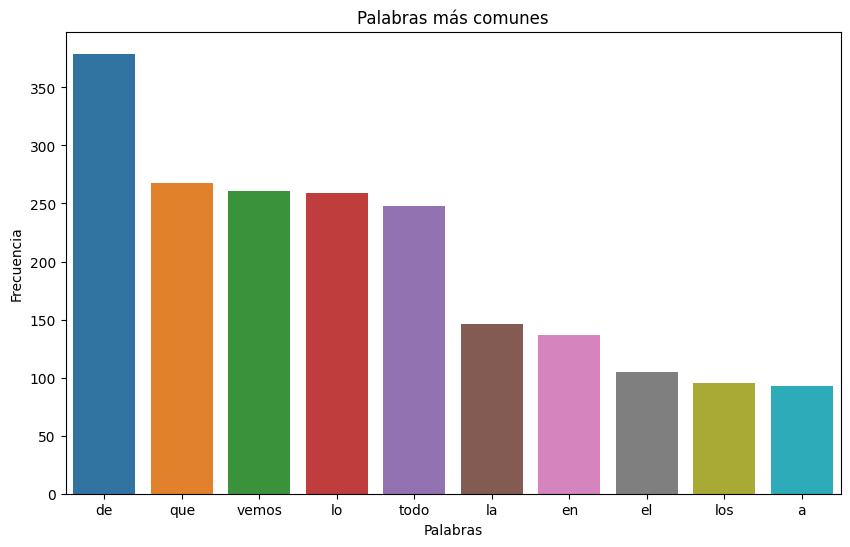

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=palabras_comunes, y=[word_frequency[palabra] for palabra in palabras_comunes])
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más comunes')
plt.show()

Se imprime la matriz TF modificada

In [39]:
print(df_tf)

     urbilogo  bogota  dominguera  historias  en  bici  sibate  pedalea  su   
0           1       1           1          0   0     0       0        0   0  \
1           0       0           0          1   1     1       1        1   1   
2           0       0           0          0   0     0       0        0   0   
3           0       0           0          0   0     0       0        0   0   
4           0       0           0          0   1     0       0        0   0   
..        ...     ...         ...        ...  ..   ...     ...      ...  ..   
995         0       0           0          0   0     0       0        0   0   
996         0       0           0          0   0     0       0        0   0   
997         0       0           0          0   0     0       0        0   0   
998         0       0           0          0   0     0       0        0   0   
999         0       0           0          0   1     0       0        0   0   

     pasado  ...  victor  firmes  nn  118  soto  ju

Se Imprime la matriz de correlación

In [40]:
print(matriz_correlacion)

                                urbilogo    bogota  dominguera  historias   
urbilogo                        1.000000  0.255347    0.576772  -0.004926  \
bogota                          0.255347  1.000000    0.446317  -0.006366   
dominguera                      0.576772  0.446317    1.000000  -0.002841   
historias                      -0.004926 -0.006366   -0.002841   1.000000   
en                             -0.020512  0.050887   -0.011831   0.242170   
...                                  ...       ...         ...        ...   
Música                         -0.011342 -0.014657   -0.006542  -0.018568   
Noticias y Política            -0.001736 -0.002243   -0.001001  -0.002841   
Película y Animación           -0.028878  0.031471   -0.016656  -0.020043   
Sin fines de lucro y Activismo -0.001736 -0.002243   -0.001001  -0.002841   
Viajes y Eventos               -0.006045 -0.007812   -0.003487  -0.009897   

                                      en      bici    sibate   pedalea   
u

Se calcula el número de títulos que contienen cada palabra

In [43]:
num_titulos_con_palabra = np.sum(matriz > 0, axis=0)

Se calcula el logaritmo del IDF para cada palabra

In [44]:
idf = np.log((len(df) + 1) / (num_titulos_con_palabra + 1))

Se crea un DataFrame vacío con las columnas de palabras_unicas

In [54]:
df_idf = pd.DataFrame(columns=palabras_unicas)

Se calcula IDF para cada título y agregarlo al DataFrame

In [52]:
for i in range(len(df['titulo'])):
    # Calcular el valor IDF para cada palabra
    idf_values = [np.log((len(df['titulo']) + 1) / (idf[j] + 1)) for j in range(len(palabras_unicas))]
    # Crear un nuevo DataFrame con los valores IDF para el título actual
    df_idf_row = pd.DataFrame([idf_values], columns=palabras_unicas)
    # Concatenar el nuevo DataFrame al DataFrame df_idf
    df_idf = pd.concat([df_idf, df_idf_row], ignore_index=True)

Se imprime la matriz IDF

In [53]:
print(df_idf)

     urbilogo    bogota  dominguera  historias        en      bici    sibate   
0    5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508  \
1    5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
2    5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
3    5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
4    5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
..        ...       ...         ...        ...       ...       ...       ...   
995  5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
996  5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
997  5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
998  5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   
999  5.033503  5.097684    4.932508   5.166268  5.796496  5.123207  4.932508   

      pedalea        su    pasado  ... 

Se multiplica la matriz de TF (matriz) por el vector IDF

In [56]:
matriz_tfidf = matriz * idf.to_numpy().reshape(1, -1)

Se divide el dataset en conjuntos de entrenamiento y prueba:

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matriz_tfidf, df['titulo'], test_size=0.2, random_state=42)

Se crea los modelos y ajústalos utilizando los conjuntos de entrenamiento:

In [63]:
# Crea una instancia del StandardScaler
scaler = StandardScaler()

# Escala los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajusta el modelo de regresión logística utilizando los datos escalados
logistic_regression.fit(X_train_scaled, y_train)

C:\Users\Esteban\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
gbm.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

Se realizan predicciones en el conjunto de prueba utilizando los modelos entrenados:

In [68]:
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_gbm = gbm.predict(X_test)

C:\Users\Esteban\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'tree_'

Se calculan las métricas para cada modelo:

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gbm = confusion_matrix(y_test, y_pred_gbm)

# Calcular las métricas de precisión, recall y exactitud (accuracy) para cada modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm, average='weighted')
recall_gbm = recall_score(y_test, y_pred_gbm, average='weighted')

Se imprimen los resultados:

In [ ]:
print("Matriz de confusión (Regresión Logística):")
print(cm_lr)
print("Accuracy (Regresión Logística):", accuracy_lr)
print("Precision (Regresión Logística):", precision_lr)
print("Recall (Regresión Logística):", recall_lr)
print()

print("Matriz de confusión (Random Forest):")
print(cm_rf)
print("Accuracy (Random Forest):", accuracy_rf)
print("Precision (Random Forest):", precision_rf)
print("Recall (Random Forest):", recall_rf)
print()

print("Matriz de confusión (GBM):")
print(cm_gbm)
print("Accuracy (GBM):", accuracy_gbm)
print("Precision (GBM):", precision_gbm)
print("Recall (GBM):", recall_gbm)